In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import scipy

In [2]:
data_dir = Path('../data/updated/')

In [3]:
def fix_neg(df, columns=['cases', 'deaths', 'recover'], verbose=False):
    for c in columns:
        cum = 'cum_%s' % c
        new = 'new_%s' % c
        before = df[cum].copy()
        non_zeros = df[df[new]>0].index
        has_negs = before.diff().min()<0
        if len(non_zeros) and has_negs:
            first_non_zero = non_zeros[0]
            maxx = df.loc[first_non_zero, cum].max()
            # Find the bad entries and null the corresponding cumulative column, which are:
            # 1) Cumulative columns which are zero after previously being non-zero
            bad = df.loc[first_non_zero:, cum]==0
            df.loc[bad[bad].index, cum] = None
            # 2) New daily columns which are negative
            bad = df.loc[first_non_zero:, new]<0
            df.loc[bad[bad].index, cum] = None
            # Protect against 0 null final value which screws up interpolator
            if np.isnan(df.loc[df.index[-1], cum]):
                df.loc[df.index[-1], cum] = maxx
            # Then run a loop which:
            while True:
                # Interpolates the cumulative column nulls to have monotonic growth
                after = df[cum].interpolate('pchip')
                diff = after.diff()
                if diff.min() < 0:
                    # If there are still negative first-differences at this point,
                    # increase the corresponding cumulative values by 1.
                    neg_index = diff[diff<0].index
                    df.loc[neg_index, cum] += 1
                else:
                    break
                # Then repeat
            plt.figure()
            plt.plot(df.index, before, label='raw')
            plt.plot(df.index, after, label='fixed')
            plt.title("%s %s Raw vs Fixed R=%.5g" % (region, c, np.corrcoef(before, after)[0, 1]))
            plt.legend()
        else:
            after = before
        # Make sure the first differences are now all non-negative
        assert after.diff().min()>=0
        # Replace the values
        df[new] = df[cum].diff().fillna(0).astype(int).values
    return df

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


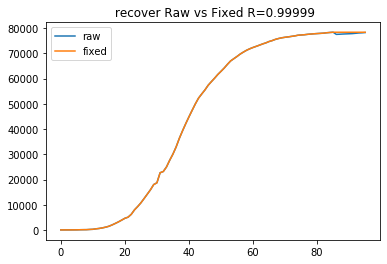

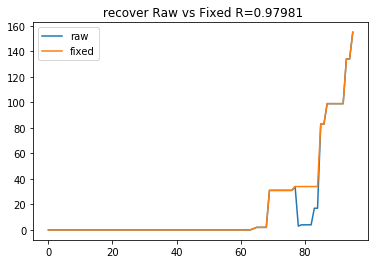

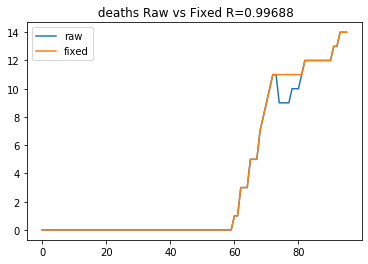

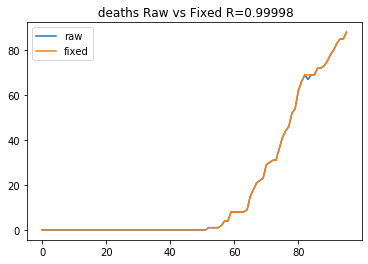

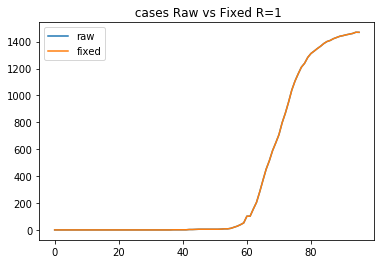

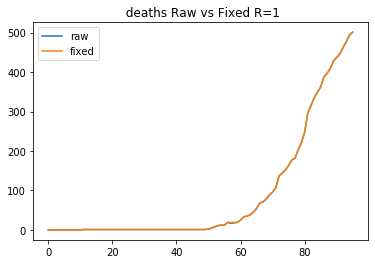

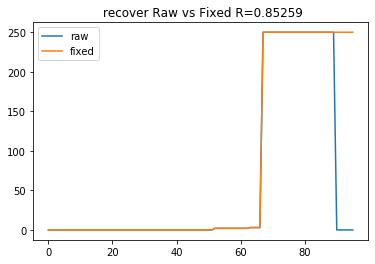

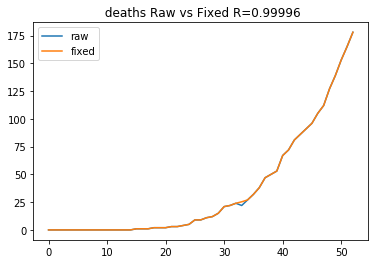

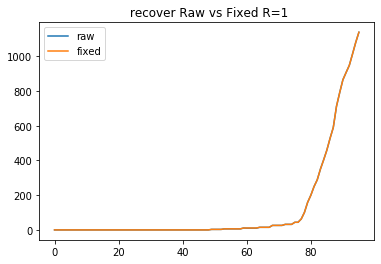

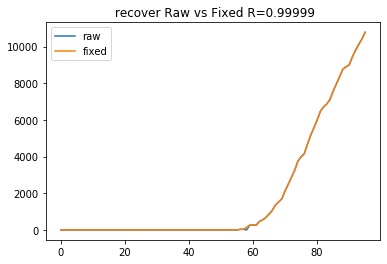

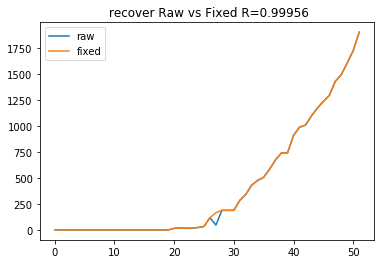

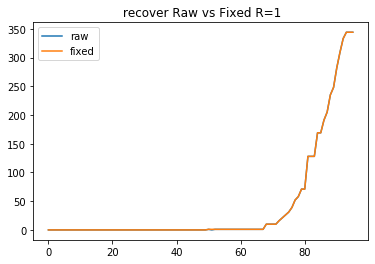

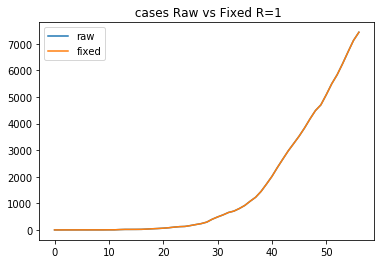

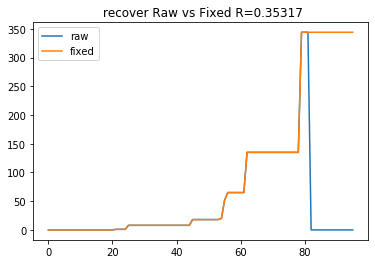

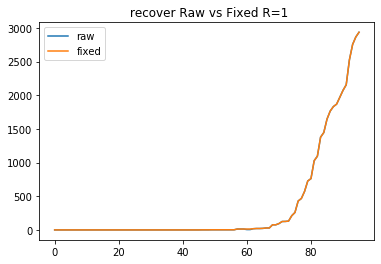

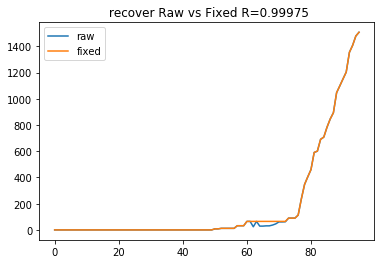

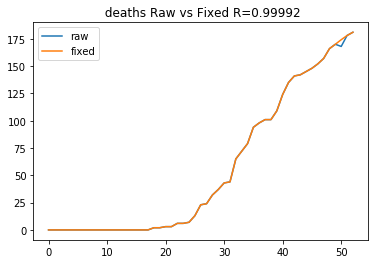

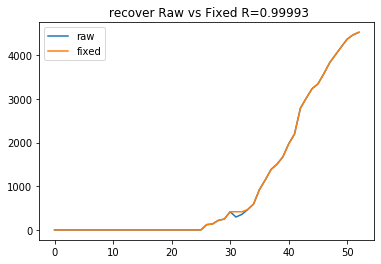

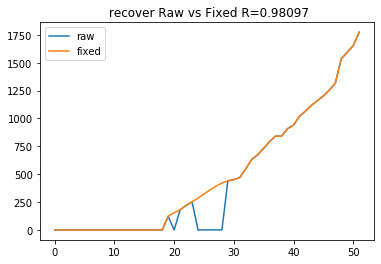

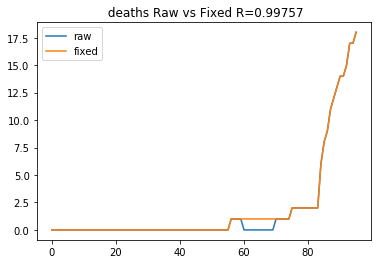

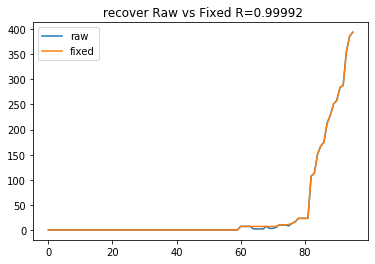

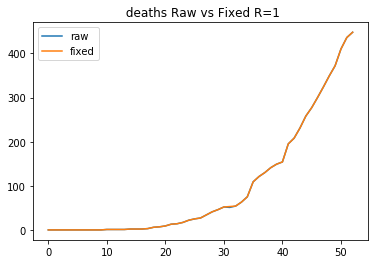

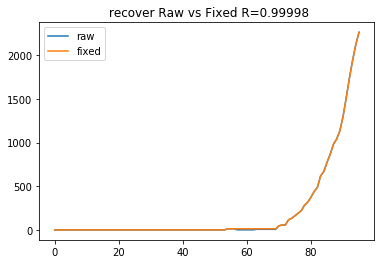

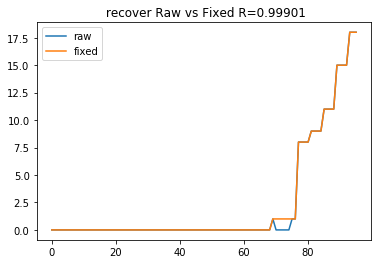

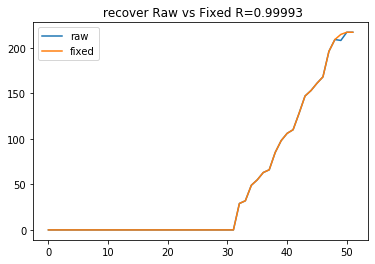

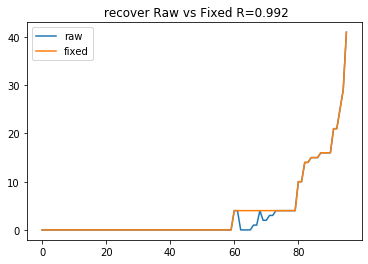

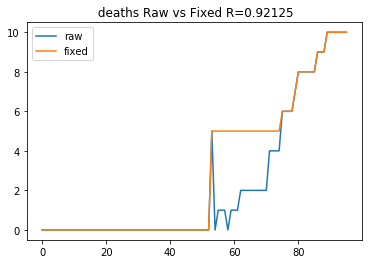

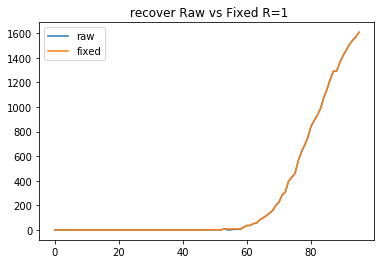

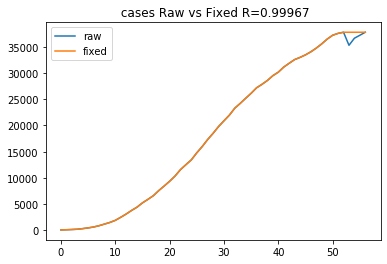

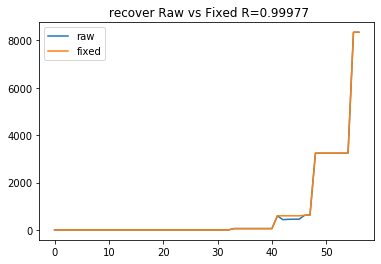

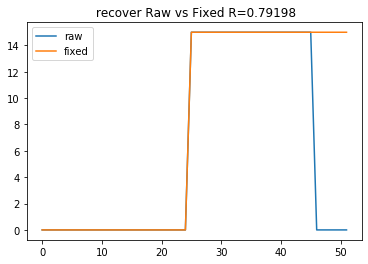

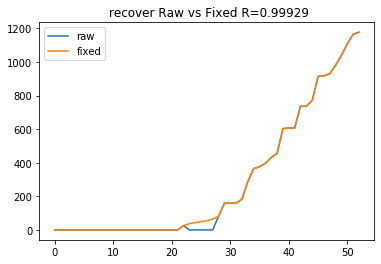

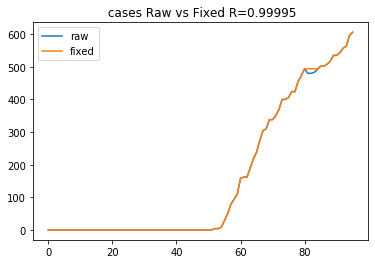

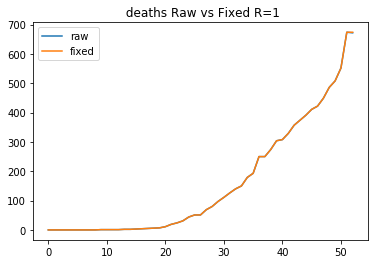

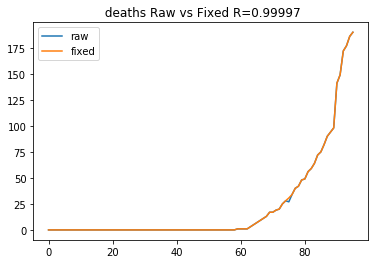

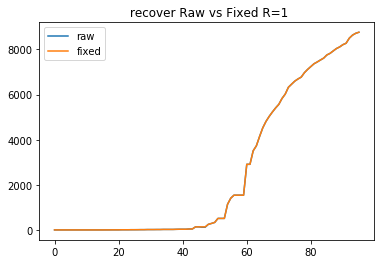

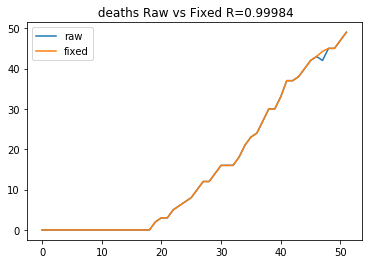

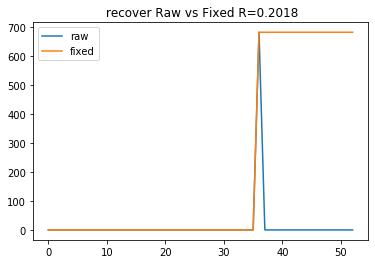

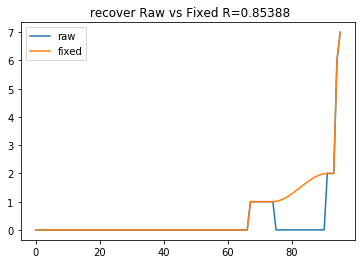

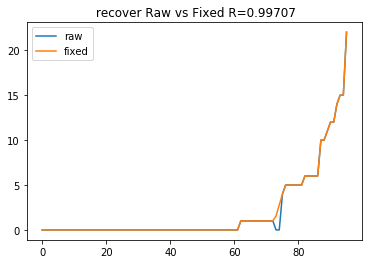

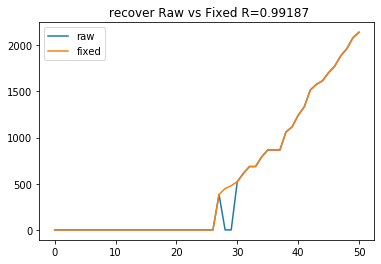

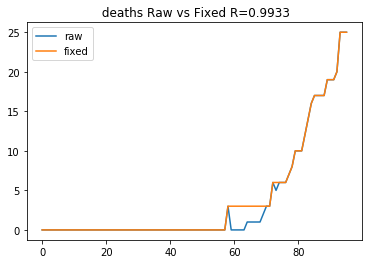

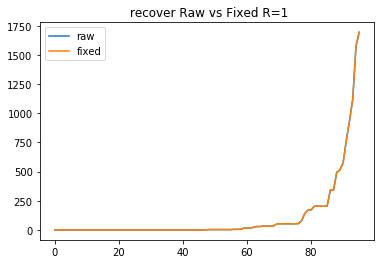

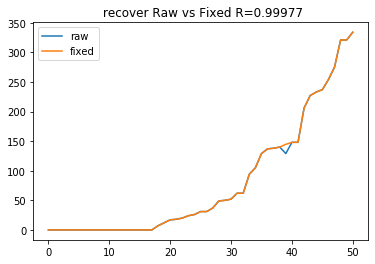

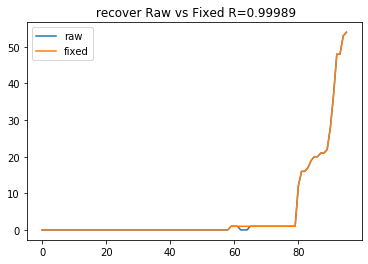

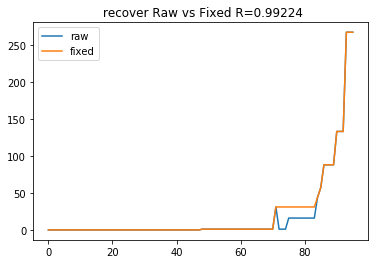

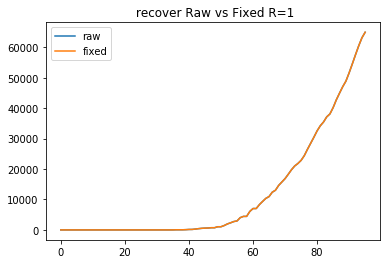

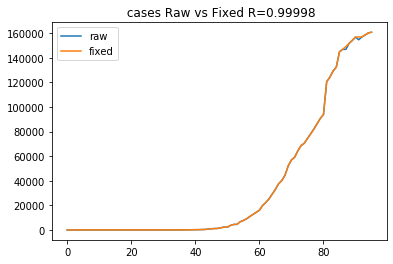

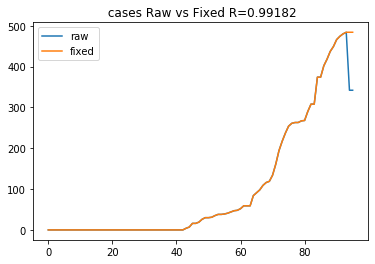

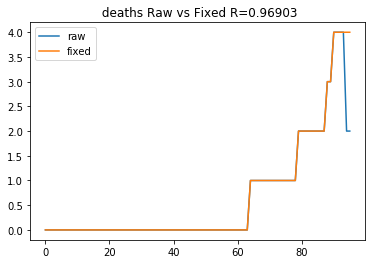

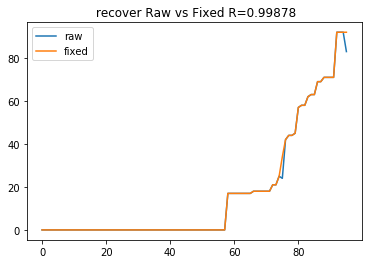

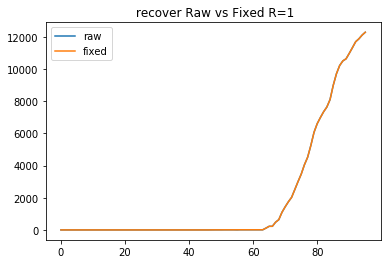

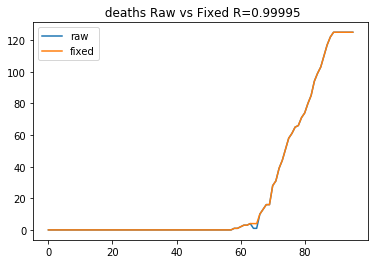

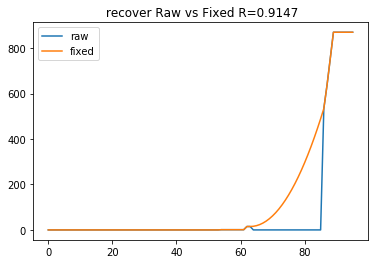

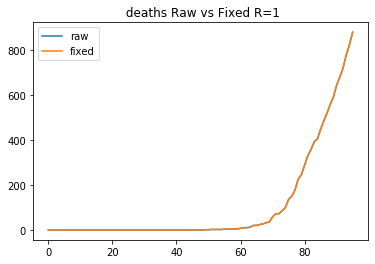

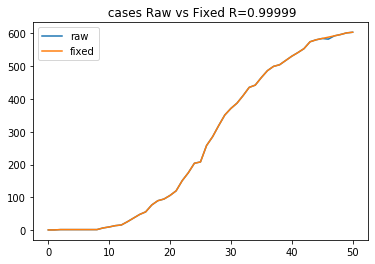

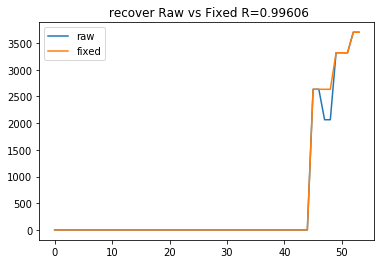

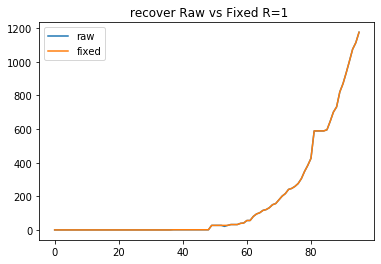

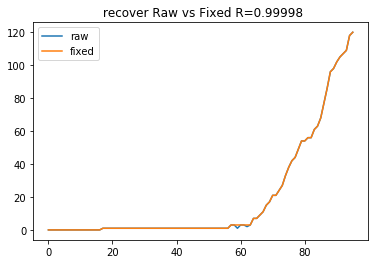

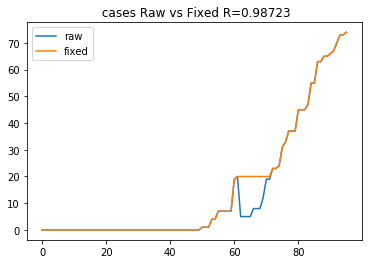

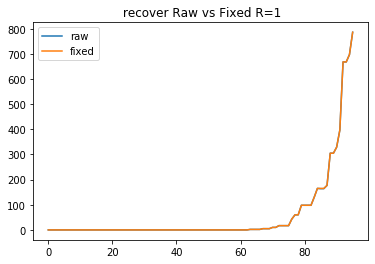

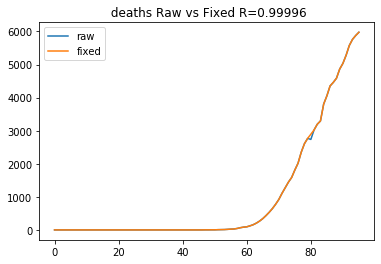

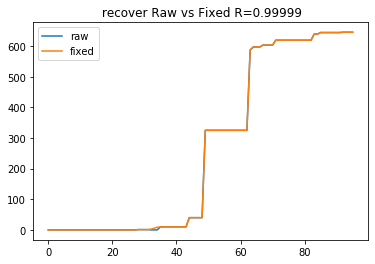

In [4]:
csvs = [x for x in data_dir.iterdir() if 'covidtimeseries' in str(x)]
counts = []
regions = []
results = pd.DataFrame(columns=['new_deaths', 'new_cases', 'new_recover', 'abs_days', 'rel_days'])
for csv in csvs:
    region = str(csv).split('.')[0].split('_')[-1]
    df = pd.read_csv(csv)
    df = df.iloc[:-1]
    df = fix_neg(df, verbose=(region=='OK'))
    df.to_csv(data_dir / (csv.name.split('.')[0]+'.csv'))